# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Classifying-newswires:-a-multiclass-classification-example" data-toc-modified-id="Classifying-newswires:-a-multiclass-classification-example-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Classifying newswires: a multiclass classification example</a></div><div class="lev2 toc-item"><a href="#Vectorize-Data-(one-hot-encoding)" data-toc-modified-id="Vectorize-Data-(one-hot-encoding)-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Vectorize Data (one-hot-encoding)</a></div><div class="lev2 toc-item"><a href="#Use-Less-Epoch" data-toc-modified-id="Use-Less-Epoch-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Use Less Epoch</a></div>

# Classifying newswires: a multiclass classification example

In this section, you’ll build a network to classify Reuters newswires into 46 mutually exclusive topics. Because you have many classes, this problem is an instance of multi- class classification; and because each data point should be classified into only one cate- gory, the problem is more specifically an instance of single-label, multiclass classification. If each data point could belong to multiple categories (in this case, topics), you’d be facing a multilabel, multiclass classification problem.

In [1]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)

2121728/2110848 [==============================] - 2s 1us/step


In [2]:
print(train_data.shape) # 2-d numpy.array(), the second tensor index corresponding data is list with different length
print(train_labels.shape) # 1-d array
print(test_data.shape)
print(test_labels.shape)

(8982,)
(8982,)
(2246,)
(2246,)


Check some decoded words/index

In [7]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()]) 
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

565248/550378 [==============================] - 2s 4us/step


In [9]:
print(decoded_newswire)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [8]:
train_labels[0]

3

## Vectorize Data (one-hot-encoding)

In [10]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [11]:
x_train = vectorize_sequences(train_data)

In [12]:
x_test = vectorize_sequences(test_data)

In [14]:
x_train.shape

(8982, 10000)

In [15]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

Note there is a Keras built-in way to do one-hot encoding.

In [16]:
from keras.utils.np_utils import to_categorical
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)


In [20]:
print(one_hot_test_labels.shape) # note, we have 46 categories

(2246, 46)


In [21]:
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

2021-11-07 03:03:47.318186: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640064    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 46)                2990      
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________


<ul>
<li> There are two other things you should note about this architecture:
You end the network with a Dense layer of size 46. This means for each input sample, the network will output a 46-dimensional vector. Each entry in this vec- tor (each dimension) will encode a different output class.</li>
<li> The last layer uses a softmax activation. You saw this pattern in the MNIST example. It means the network will output a probability distribution over the 46 different output classes—for every input sample, the network will produce a 46- dimensional output vector, where output[i] is the probability that the sample belongs to class i. The 46 scores will sum to 1. </li>
</ul>

In [23]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
# defin validation data
x_val = x_train[:1000] # fist 1k validation data
partial_x_train = x_train[1000:] # the rest are training data
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [25]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

2021-11-07 03:07:13.971838: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
16/16 [==============================] - 1s 27ms/step - loss: 2.5278 - accuracy: 0.5289 - val_loss: 1.7287 - val_accuracy: 0.6310
Epoch 2/20
16/16 [==============================] - 0s 15ms/step - loss: 1.4204 - accuracy: 0.6912 - val_loss: 1.3344 - val_accuracy: 0.6950
Epoch 3/20
16/16 [==============================] - 0s 15ms/step - loss: 1.0803 - accuracy: 0.7590 - val_loss: 1.1600 - val_accuracy: 0.7450
Epoch 4/20
16/16 [==============================] - 0s 14ms/step - loss: 0.8566 - accuracy: 0.8126 - val_loss: 1.0449 - val_accuracy: 0.7870
Epoch 5/20
16/16 [==============================] - 0s 15ms/step - loss: 0.6910 - accuracy: 0.8525 - val_loss: 0.9877 - val_accuracy: 0.7900
Epoch 6/20
16/16 [==============================] - 0s 14ms/step - loss: 0.5515 - accuracy: 0.8845 - val_loss: 0.9305 - val_accuracy: 0.8030
Epoch 7/20
16/16 [==============================] - 0s 14ms/step - loss: 0.4388 - accuracy: 0.9102 - val_loss: 0.8954 - val_accuracy: 0.8110
Epoch 8/20
16

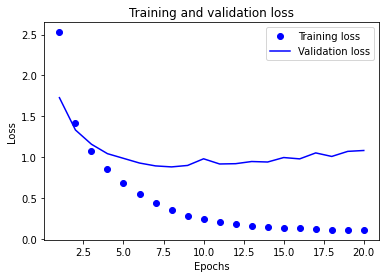

In [26]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


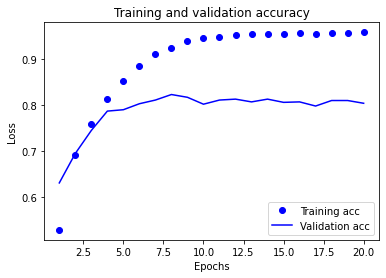

In [28]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Use Less Epoch

In [29]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 24ms/step - loss: 2.6300 - accuracy: 0.5286 - val_loss: 1.6999 - val_accuracy: 0.6420
Epoch 2/9
16/16 [==============================] - 0s 15ms/step - loss: 1.4041 - accuracy: 0.7086 - val_loss: 1.2693 - val_accuracy: 0.7300
Epoch 3/9
16/16 [==============================] - 0s 14ms/step - loss: 1.0351 - accuracy: 0.7854 - val_loss: 1.1099 - val_accuracy: 0.7720
Epoch 4/9
16/16 [==============================] - 0s 15ms/step - loss: 0.8097 - accuracy: 0.8320 - val_loss: 1.0165 - val_accuracy: 0.7840
Epoch 5/9
16/16 [==============================] - 0s 14ms/step - loss: 0.6425 - accuracy: 0.8647 - val_loss: 1.0173 - val_accuracy: 0.7690
Epoch 6/9
16/16 [==============================] - 0s 15ms/step - loss: 0.5202 - accuracy: 0.8882 - val_loss: 0.9027 - val_accuracy: 0.8160
Epoch 7/9
16/16 [==============================] - 0s 14ms/step - loss: 0.4179 - accuracy: 0.9132 - val_loss: 0.8964 - val_accuracy: 0.8170
Epoch 8/9
16/16 [===

In [50]:
x_test[0].shape

(10000,)

In [45]:
x_test[0:2].shape

(2, 10000)

In [49]:
# note, when we want to do prediction, if the input is one sample, then need to match the input dimension
model.predict(x_test[0].reshape(1, 10000)).shape

(1, 46)

In [48]:
# predicts multiple samples are also possible
model.predict(x_test[0:2]).shape

(2, 46)